# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

%matplotlib notebook
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | head -n 5

{"movieId": 2, "userId": 1, "timestamp": 1112486027, "rating": 3.5}
{"movieId": 29, "userId": 1, "timestamp": 1112484676, "rating": 3.5}
{"movieId": 32, "userId": 1, "timestamp": 1112484819, "rating": 3.5}
{"movieId": 47, "userId": 1, "timestamp": 1112484727, "rating": 3.5}
{"movieId": 50, "userId": 1, "timestamp": 1112484580, "rating": 3.5}
cat: Unable to write to output stream.


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 Basic statistics
First, we will look at basic statistics on this dataset.
* Plot the number of ratings for each user.
* Plot the number of ratings for each item.

Is the number of ratings balanced uniformly across users and movies?

In [4]:
UID = data.map(lambda x: (x["userId"], 1))
UID_count = UID.reduceByKey(lambda a, b: a + b)
user_ratings = np.array(UID_count.collect())

Text(0, 0.5, 'Number of ratings')

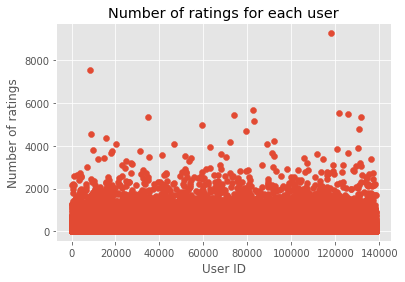

In [6]:
userID = user_ratings[:,0]
Number_ratings = user_ratings[:,1]
plt.scatter(userID,Number_ratings)
plt.title('Number of ratings for each user')
plt.xlabel('User ID')
plt.ylabel('Number of ratings')

In [7]:
UID = data.map(lambda x: (x["movieId"], 1))
UID_count = UID.reduceByKey(lambda a, b: a + b)
item_ratings = np.array(UID_count.collect())

Text(0, 0.5, 'Number of ratings')

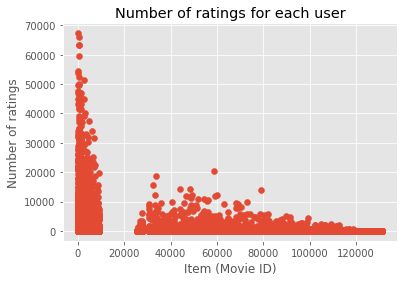

In [8]:
Item = item_ratings[:,0]
Number_ratings = item_ratings[:,1]
plt.scatter(Item,Number_ratings)
plt.title('Number of ratings for each user')
plt.xlabel('Item (Movie ID)')
plt.ylabel('Number of ratings')

With the two previous graphs, we observe that about all users gave rates but not all the items are rated. Thus the number of ratings is not balanced uniformly across users and movies.

## Exercise 3.5 Partitioning the dataset
In order to tune hyperparameters and evaluate the recommender system’s performance, we
will split the data into a training and a validation set.
* Append your personal ratings to the MovieLens dataset RDD.
* Partition the data into two sets: ≈ 80% for training, and ≈ 20% for validation.

**Hint**: A convenient way to split the data is to filter on the last digit of the rating’s timestamp

### Adding my personal ratings

In [137]:
lines = [{"movieId": 1, "userId": 138494, "timestamp": 1588151184, "rating": 3},
{"movieId": 1210, "userId": 138494, "timestamp": 1588151192, "rating": 2},
{"movieId": 648, "userId": 138494, "timestamp": 1588151195, "rating": 3},
{"movieId": 153, "userId": 138494, "timestamp": 1588151209, "rating": 3}]
# Append to the Hdfs ratings.txt file
my_rates = sc.parallelize(lines)
print(my_rates.take(10))
data = data.union(my_rates)

[{'movieId': 1, 'userId': 138494, 'timestamp': 1588151184, 'rating': 3}, {'movieId': 1210, 'userId': 138494, 'timestamp': 1588151192, 'rating': 2}, {'movieId': 648, 'userId': 138494, 'timestamp': 1588151195, 'rating': 3}, {'movieId': 153, 'userId': 138494, 'timestamp': 1588151209, 'rating': 3}]


Now our rates are appended to the whole dataset

### Partitioning the dataset

In [5]:
def RDDfilter80(line):
    """Filters the RDD in order to keep ~80% of the Data for training"""
    keep = True
    if line['timestamp']%10 in [0,1]:
        keep = False
    return(keep)

def RDDfilter20(line):
    """Filters the RDD in order to keep ~20% of the Data for training"""
    keep = False
    if line['timestamp']%10 in [0,1]:
        keep = True
    return(keep)

# Filters the dataset to split it into 2 datasets
# it uses the last digit of the timestamp to do it 
# if the digit is in [0,1] it will be taken for the test dataset and
# if the digit is in [2,3,4,5,6,7,8,9] it will be put in the training dataset
train = data.filter(RDDfilter80)
test = data.filter(RDDfilter20)

In [15]:
ratio_train = train.count()/data.count()
ratio_test = test.count()/data.count()
print('The training partition represents '+str(round(ratio_train*100,2)) +'% of the data')
print('The test partition represents '+str(round(ratio_test*100,2)) +'% of the data')

The training partition represents 80.0% of the data
The test partition represents 20.0% of the data


## Exercise 3.6 Baseline model

You will first implement a recommender system based on model (3.1).
* Compute the global mean µ , the user biases {α u } and the item biases {β m } using a
sequence of RDD transformations on the training set.
* How many parameters does this model have?
* Predict the rating of every user / movie pair in the validation set.

**Note**: some users / movies do not have any ratings. Use sensible default values for α u and β m 

We used the following formulas :
$$\mu = \frac{1}{N}\sum_{u,m}^{} r_{um}$$
    $$\alpha_{u} = \frac{1}{N_{u}}\sum_{m}^{} (r_{um}-\mu)$$
$$\beta_{m} = \frac{1}{N_{m}}\sum_{u}^{} (r_{um}-\alpha_{u}-\mu)$$

In [7]:
# Definition of some parameters
N = train.count() 

In [8]:
# Get the Nm for each movie
data_mov = train.map(lambda x: (x['movieId'],1))
count_movie = data_mov.reduceByKey(lambda a,b:a+b)
Nm = dict(count_movie.collect())

In [9]:
# Get the Nu for each u
data_user = train.map(lambda x: (x['userId'],1))
count_user = data_user.reduceByKey(lambda a,b:a+b)
Nu = dict(count_user.collect())

In [10]:
# Computes the global average
rum = train.map(lambda x: x["rating"])
mu = rum.sum()/N
print("µ = "+str(mu))

µ = 3.5255074148553356


The following snippet of code computes the $\alpha_{u}$ for each user

In [11]:
def reducer(r1,r2):
    return(r1+r2)

rum = train.map(lambda x:(x["userId"], x["rating"]))
rum_uid = rum.reduceByKey(reducer)
alpha_uid = rum_uid.collect()

def calc_alpha(x):
    uid, sum_rum = x
    s = sum_rum/Nu[int(uid)] - mu
    return s

# Terminate calculations
tab = np.array(alpha_uid)
alpha_user = pd.DataFrame(tab) 
alpha_user['alpha_u'] = alpha_user.apply(calc_alpha, axis=1)
alpha_user.columns = ["uId", "rum_sum", "alpha_u"]
alpha_user

,uId,rum_sum,alpha_u
0,12.0,120.0,0.003904
1,24.0,1421.0,-0.197639
2,36.0,46.0,-0.819625
3,48.0,336.0,0.427434
4,60.0,236.5,0.482967
...,...,...,...
138452,136859.0,71.0,-0.685507
138453,136871.0,256.5,0.302851
138454,136883.0,122.5,0.698631
138455,136895.0,675.5,0.125844


We finally get, a dataframe with the user ID and the corresponding $\alpha_{u}$

The following snippet of code computes the $\beta_{u}$ for each item
$$\beta_{m} = \frac{1}{N_{m}}(\sum_{u}^{} r_{um} -\sum_{u}^{} \alpha_{u})-\mu$$

In [141]:
def reducer(r1,r2):
    return(r1+r2)

# GROUPBY Movie ID and sum the ratings
rum = train.map(lambda x:(x["movieId"], x["rating"]))
rum_mId = rum.reduceByKey(reducer)
rum_mId = rum_mId.collect()

# Store it in a dataframe
tab = np.array(rum_mId)
beta_mId = pd.DataFrame(tab) 
beta_mId.columns = ["movieId", "rum_sum"]
beta_mId.head()

,movieId,rum_sum
0,924.0,79880.0
1,1080.0,65393.0
2,1584.0,58002.5
3,1848.0,3529.0
4,1920.0,8428.5


In [233]:
# Run it to regenerate Beta otherwise they are stored in a file.
def reducer(r1,r2):
    return(r1+r2)
def get_alpha_u(u):
    return(alpha_user[alpha_user['uId']==int(u)]['alpha_u'].values[0])

# Create couples (Movie ID, alpha_u)
rum = train.map(lambda x:(x["movieId"],get_alpha_u(x["userId"])))
rum_mId = rum.reduceByKey(reducer)
res = rum_mId.collect()
# np.save("resultat_sum_alpha_u_movie_m", res)

In [142]:
if not("res" in locals()):
    # Load data if already computed
    res = np.load("resultat_sum_alpha_u_movie_m.npy")
    
alpha_um = dict(res)

def calc_beta(x):
    movieId, sum_rum = x
    s = (sum_rum-alpha_um[int(movieId)])/Nm[int(movieId)] - mu
    return s

# Perform the computations to get beta and store it in the dataframe
beta_mId['beta_m'] = beta_mId.apply(calc_beta, axis=1)
beta_mId.head()

,movieId,rum_sum,beta_m
0,924.0,79880.0,0.347113
1,1080.0,65393.0,0.401877
2,1584.0,58002.5,0.105468
3,1848.0,3529.0,-0.429849
4,1920.0,8428.5,-0.607751


In [143]:
#Bakup from the data in order to load them without recomputing them
np.save('N', N)
np.save('Nu', Nu)
np.save('Nm', Nm)
np.save('mu', mu)
np.save('alpha_user', alpha_user)
np.save('beta_mId', beta_mId)

Now we have computed all what we needed to compute the predicted rate.

This model has only **two** parameters which are $u,m$

Now to perform the prediction we used the folowing formula :

$$\hat r_{um} = \mu + \alpha_{u} + \beta_{m}$$

In [ ]:
# Load the data from the bakup, if computation has already be done
N = np.load('N.npy')
Nu = np.load('Nu.npy')
Nm = np.load('Nm.npy')
mu = np.load('mu.npy')
alpha_user = np.load('alpha_user.npy')
beta_mId = np.load('beta_mId.npy')

In [15]:
# Functions to attributes the alpha_u and beta_m
# If nothing is rated it attributes the mean of the corresponding ratings
alpha_default = alpha_user["alpha_u"].mean()
beta_default = beta_mId["beta_m"].mean()

def get_alpha(u):
    """Returns the corresponding alpha for the user u
    If the data is missing, the average of the alpha is returned"""
    #   Check Alpha
    search_alpha = alpha_user[alpha_user["uId"]==u]["alpha_u"].values
    if len(search_alpha)==0:
        alpha = alpha_default
    else:
        alpha = search_alpha[0]
    return (alpha)

def get_beta(m):
    """Returns the corresponding beta for the movie m
    If the data is missing, the average of the beta is returned"""
    #   Check Beta
    search_beta = beta_mId[beta_mId['movieId']==m]["beta_m"].values
    if len(search_beta)==0:
        beta = beta_default
    else:
        beta = search_beta[0]
    return(beta)

def predict(u,m):
    """return the prediction of the rate for user u and movie m"""
#   Get Alpha
    search_alpha = alpha_user[alpha_user["uId"]==u]["alpha_u"].values
    if len(search_alpha)==0:
        alpha = alpha_default
    else:
        alpha = search_alpha[0]
#   Get Beta
    search_beta = beta_mId[beta_mId['movieId']==m]["beta_m"].values
    if len(search_beta)==0:
        beta = beta_default
    else:
        beta = search_beta[0]
#     Finally perform the sum
    val=mu+alpha+beta
    return val

In [16]:
# To fetch the data from the test or validation dataset 
test_np = test.collect()
df = pd.DataFrame(test_np)
df.head()

In [ ]:
# Attributes the alpha_u and beta_m to each (u, m) couples
df["alpha_u"] = df[["userId"]].apply(lambda x : get_alpha(x["userId"]), axis=1)
df["beta_m"] = df[["movieId"]].apply(lambda x : get_beta(x["movieId"]), axis=1)

In [152]:
df.head(5)

,movieId,userId,timestamp,rating,alpha_u,beta_m
0,50,1,1.112485e+09,3.5,0.233358,0.709089
1,112,1,1.094786e+09,3.5,0.233358,-0.070359
2,253,1,1.112485e+09,4.0,0.233358,-0.037220
3,367,1,1.112486e+09,3.5,0.233358,-0.365010
4,593,1,1.112485e+09,3.5,0.233358,0.543904


In [36]:
# Perform the addition of the columns containing alpha_u and beta_m and add the mean to them
tab = df.to_numpy()
rum_pred = tab[:,4]+tab[:,5]+mu 
df["rum_pred"] = rum_pred
# Save the dataset after all the computations are done
np.save("df",df.values)

In [156]:
df.head()

,movieId,userId,timestamp,rating,alpha_u,beta_m,rum_pred
0,50,1,1.112485e+09,3.5,0.233358,0.709089,4.467954
1,112,1,1.094786e+09,3.5,0.233358,-0.070359,3.688506
2,253,1,1.112485e+09,4.0,0.233358,-0.037220,3.721645
3,367,1,1.112486e+09,3.5,0.233358,-0.365010,3.393855
4,593,1,1.112485e+09,3.5,0.233358,0.543904,4.302769


Now our predictions are done, thus we can compare them with the real data.

## Exercise 3.7 Evaluation
Implement a function error() that takes an RDD containing (userId, movieId, rating)
triplets and computes the error (3.2) with respect to the validation set.
• Use this function to evaluate the baseline predictions that you computed previously.
You should obtain an error of approximately 0.867. 

In [153]:
# Load the Dataset containing the preceding data
df = np.load("df.npy")
df = pd.DataFrame(df)
df.columns = ["movieId", "userId","timestamp", "rating", "alpha_u", "beta_m", "rum_pred"]
df = df.astype({'movieId': 'int32', 'userId': 'int32'})
df.head(5)

,movieId,userId,timestamp,rating,alpha_u,beta_m,rum_pred
0,50,1,1.112485e+09,3.5,0.233358,0.709089,4.467954
1,112,1,1.094786e+09,3.5,0.233358,-0.070359,3.688506
2,253,1,1.112485e+09,4.0,0.233358,-0.037220,3.721645
3,367,1,1.112486e+09,3.5,0.233358,-0.365010,3.393855
4,593,1,1.112485e+09,3.5,0.233358,0.543904,4.302769


In [131]:
def error():
    # Get the Nu for each u
    data_user = test.map(lambda x: (x['userId'],1))
    count_user = data_user.reduceByKey(lambda a,b:a+b)
    Nu = dict(count_user.collect())
    
    users = df["userId"].unique()
    U = len(users)
    s = 0
    # Compute the error formula     
    df['delta^2'] = (df["rum_pred"]-df["rating"])**2
    delta_by_user = df.groupby("userId").sum()

    for u in users:
        s += np.sqrt((1/Nu[u])*delta_by_user[delta_by_user.index.astype(int)==u]['delta^2'].values[0])
    err = (1/U)* s
    return err
    
err = error()
print("We get an error of "+str(round(err,4)))

We get an error of 0.8684


Hence we can say that our recommender system is about **0.8684** from the perfect recommandations. It can be 0.8684 above or below the real value.